# Классификация ориентации справки
-  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org - где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.  Далее загружает как картинку или pdf в личный кабинет. Раньше операторами платформы все донации верифицировались вручную. Был разработан сервис OCR (optical character recognition) для распознавания табличной информации на бланке справки и записи результатов в .csv файл. Существующая версия сервиса требует вертикальной ориентации справки, однако с точки зрения удобства пользователя хотелось бы обрабатывать справки независимо от их ориентации.

## Цель исследования

Разработать модель определения ориентации справки и автоматического поворота ее в нормальное положение перед запуском сервиса OCR.

## Задачи проекта

+ Исследование существующих подходов к решению задачи.  
+ Выбор готовой или обучение собственной модели компьютерного зрения для определения ориентации изображения  
+ Тестирование модели, определение метрик  
+ Подготовка скриптов для препроцессинга изображения, инференса модели и постпроцессинга изображения  
+ Создание микросервиса для последующей интеграции в продукт заказчика  


## Загрузка данных

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import random
from google.colab import drive
import torchvision.transforms.v2 as v2
import torch
import cv2
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision.models import squeezenet1_0,mobilenet_v2
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 16
generator = torch.Generator().manual_seed(1001)
np.random.seed(1001)
random.seed(1001)

In [ ]:
image_folder = '/content/drive/MyDrive/детекция/images/'
labels_folder = '/content/drive/MyDrive/детекция/разметка.txt'

In [ ]:
def open_images(path):
    img = [cv2.imread(os.path.join(path, filename)) for filename in natsorted(os.listdir(path)) ]
    return img
def vizualize_images(images,labels,count_of_images):
  for k,(i,j) in enumerate(zip(images,labels)):
    if k == count_of_images:
      break
    plt.imshow(i)
    plt.title(j)
    plt.show()
def open_file_txt(path):
    with open (path, 'r') as f:
        for row in f:
            s = list(row.strip())
    return s
images = open_images(image_folder)
labels = open_file_txt(labels_folder)
labels = list(map(int,labels))

**Вывод**: Я пометил изображения следующим образом:  
0- стандартное  
1-повернутое влево на 90 градусов  
2 - перевернутое   
3- повернутое вправо на 90 градусов   
Датасет состоит в основном из справок с положением 0 (стандратное положение), а также встречаются скриншоты с госуслуг. Поскольку наблюдается явный диcбаланс классов. Следующим этапом проведу аугментацию изображений.   
Поскольку датасет состоит из реальных фотографий справок, я не имею право визуализировать какую-либо конфиденциальную информацию

## Аугментация изображений

Разделю данные на тренировочную, валидационную и тестовую выборку

In [ ]:
image_train,image_valid,label_train,label_valid = train_test_split(images,labels , train_size=0.6 , random_state=1001, shuffle=True)
image_valid,image_test,label_valid,label_test = train_test_split(image_valid,label_valid , train_size=0.5 , random_state=1001, shuffle=True)

In [ ]:
def check_rotation(label, rotation):
    help_rotator = {
        0: 0,
        90: 1,
        180: 2,
        270: 3
    }
    new_label = (label + help_rotator[rotation]) % 4
    return new_label

def augmented_images(images, labels, is_train):
    final_images = []
    final_labels = []
    for image, label in zip(images, labels):
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        choices = [0, 90, 180, 270]
        angle = np.random.choice(choices)
        h, w = image.shape[:2]
        center = (h // 2, w // 2)
        test_label = check_rotation(label, angle)
        if is_train:
            m = cv2.getRotationMatrix2D(center, angle= -angle, scale=np.random.uniform(1, 1.5))
        else:
            m = cv2.getRotationMatrix2D(center, angle = -angle, scale = 1)
        rotated_image = cv2.warpAffine(image, m, (w, h))
        if is_train:
          checker = np.random.randint(0,2)
          if checker ==1:
            noise = np.random.normal(0, 0.7, rotated_image.shape).astype(np.uint8)
            noisy_image = cv2.add(rotated_image, noise)
          else:
            blurred = cv2.GaussianBlur(rotated_image, (9, 9), 10.0)
            rotated_image = cv2.addWeighted(rotated_image, 1.1, blurred, -0.5, 0)




        final_images.append(rotated_image)
        final_labels.append(test_label)

    return final_images, final_labels

augmented1_images, augmented1_labels = augmented_images(image_train, label_train, True)


В данном случае для каждой из выборок я поворачиваю изображение на 1 из предложенных углов. Если изображение из тренировочной выборки, тогда я дополнительно увеличиваю изображение и также добавляю гаусов шум.

In [ ]:
validated_images, validated_labels =  augmented_images(image_valid,label_valid, False)
tested_images, tested_labels =  augmented_images(image_test,label_test, False)

## Подготовка данных к обучению

Все изображения будут преобразованы в тензоры и приведены к единому размеру 224x224. Кроме того, для дальнейшей обработки изображения будут нормализованы.

In [ ]:
transform_augment = transforms.Compose([  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

In [ ]:
for i in range(len(augmented1_images)):
  augmented1_images[i] = transform_augment(augmented1_images[i])
for i in range(len(validated_images)):
  validated_images[i] = transform_augment(validated_images[i])
for i in range(len(tested_images)):
  tested_images[i] = transform_augment(tested_images[i])



In [ ]:
augmented1_images = torch.stack(augmented1_images)
final_valid_images = torch.stack(validated_images)
final_test_images = torch.stack(tested_images)

In [ ]:
augmented1_labels = torch.tensor(augmented1_labels)
validated_labels = torch.tensor(validated_labels)
tested_labels = torch.tensor(tested_labels)

In [ ]:
dataset_train = TensorDataset(augmented1_images,augmented1_labels)
dataset_valid = TensorDataset(final_valid_images,validated_labels)
dataset_test = TensorDataset(final_test_images,tested_labels)

In [ ]:
train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)


**Вывод**: Данные загружены, далее перейду к обучению моделей.

## Обучение моделей

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
  model.train()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0
  for inputs , labels  in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion (outputs , labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)
  scheduler.step()
  train_loss = running_loss / processed_data
  train_acc = running_corrects.numpy() / processed_data
  return train_loss, train_acc








In [ ]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_size = 0
  for inputs, labels in val_loader:
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_corrects.cpu().numpy() / processed_size
  return val_loss, val_acc

In [ ]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels in test_loader:
            model.eval()
            outputs = model(inputs)
            logits.append(outputs)
            preds.append(torch.argmax(outputs, 1))
            answers.append(labels)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.numpy() / processed_size
    return answers, preds, probs, test_acc

In [ ]:
def train(train, val, model, epochs, rate, criterion):
  history = []
  opt = torch.optim.Adam(model.parameters(), lr=rate)
  sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)
  for epoch in range(epochs):
    train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)
    val_loss, val_acc = eval_epoch(model, val, criterion)
    history.append((train_loss, train_acc, val_loss, val_acc))
  return history

### ResNet18

In [ ]:
weights_18 = ResNet18_Weights.DEFAULT
resnet_18 = resnet18(weights=weights_18)


for param in resnet_18.parameters():
    param.requires_grad = False

layers = list(resnet_18.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 512
out_features = 4
resnet_18.fc = nn.Linear(in_features, out_features)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [ ]:
ce = nn.CrossEntropyLoss()
lr = 3e-4

In [ ]:
history_18 = train(train_dataloader, valid_dataloader, model=resnet_18, epochs=6, rate=lr, criterion=ce)

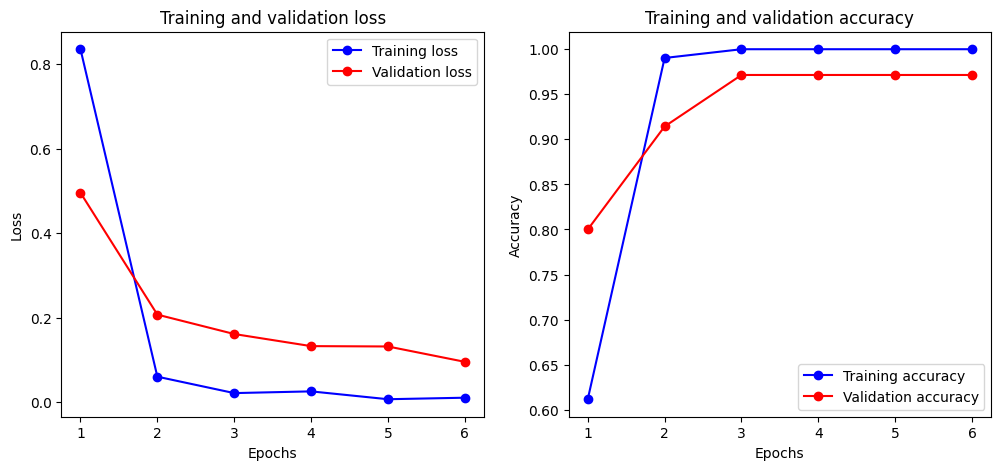

In [ ]:
train_losses = [x[0] for x in history_18]
train_accuracies = [x[1] for x in history_18]
val_losses = [x[2] for x in history_18]
val_accuracies = [x[3] for x in history_18]

# Количество эпох
epochs = range(1, len(history_18) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Resnet50

In [ ]:
weights_50 = ResNet50_Weights.DEFAULT
resnet_50 = resnet50(weights=weights_50)

# Set requires_grad = False for all parameters
for param in resnet_50.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet_50.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet_50.fc = nn.Linear(in_features, out_features)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


In [ ]:
history_50 = train(train_dataloader, valid_dataloader, model=resnet_50, epochs=4, rate=lr, criterion=ce)

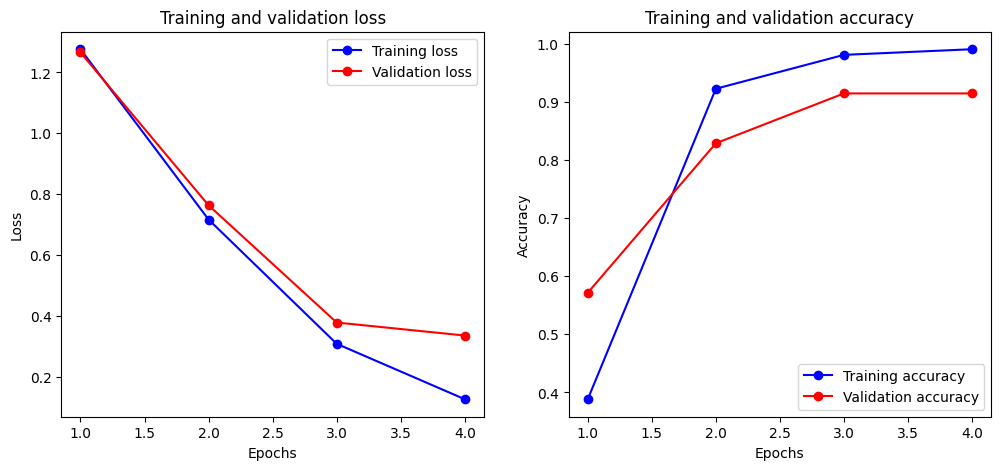

In [ ]:
train_losses = [x[0] for x in history_50]
train_accuracies = [x[1] for x in history_50]
val_losses = [x[2] for x in history_50]
val_accuracies = [x[3] for x in history_50]

# Количество эпох
epochs = range(1, len(history_50) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Squezze

In [ ]:
squezze = squeezenet1_0(pretrained=True)
# Заменяем последний слой классификации на 4 класса
squezze.classifier[1] = nn.Conv2d(512, 4, kernel_size=(1, 1), stride=(1, 1))
squezze.num_classes = 4
for param in squezze.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 76.4MB/s]


In [ ]:
hist_squezze = train(train_dataloader, valid_dataloader, model = squezze, epochs = 20, rate=lr, criterion=ce)

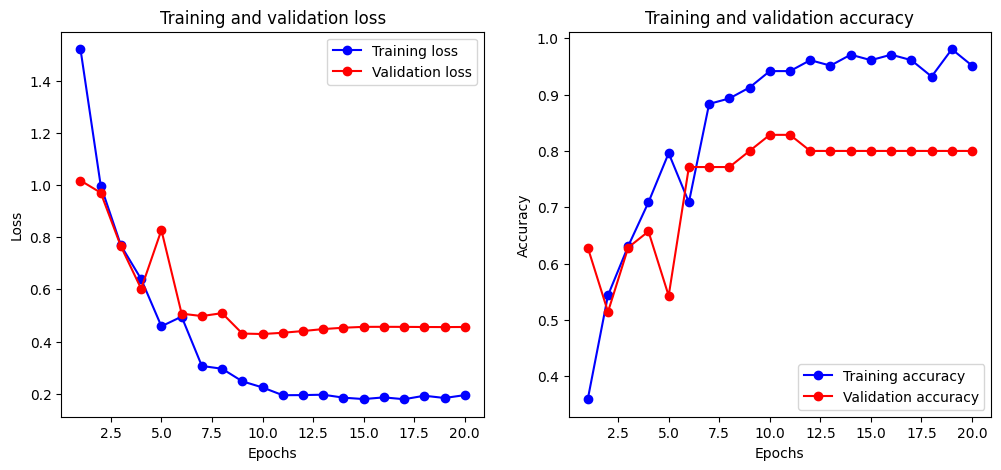

In [ ]:
train_losses = [x[0] for x in hist_squezze]
train_accuracies = [x[1] for x in hist_squezze]
val_losses = [x[2] for x in hist_squezze]
val_accuracies = [x[3] for x in hist_squezze]

# Количество эпох
epochs = range(1, len(hist_squezze) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
hist_squezze[-1][-1]

0.8

## MobileNet

In [ ]:
mobilenet = mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.5, inplace=False),
                  nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=4, bias=True))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 50.9MB/s]


In [ ]:
hist_mobile = train(train_dataloader, valid_dataloader, model = mobilenet, epochs = 6, rate=lr, criterion=ce)

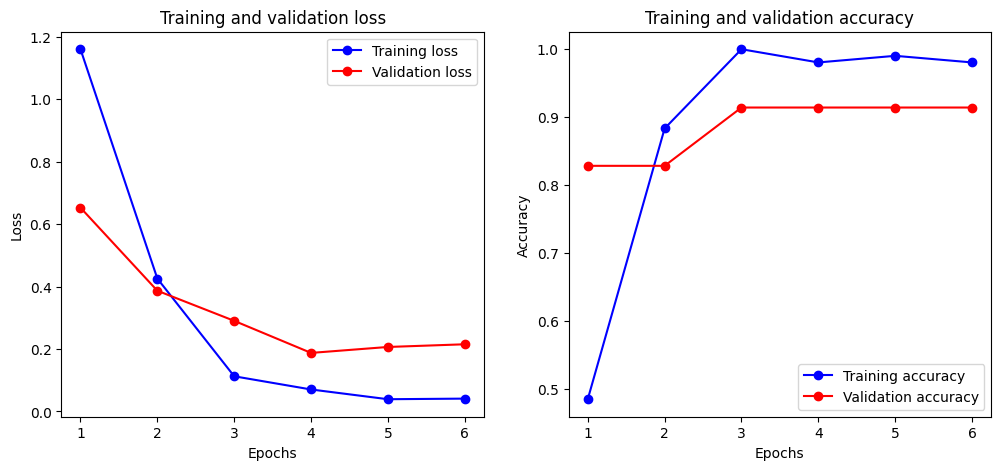

In [ ]:
train_losses = [x[0] for x in hist_mobile]
train_accuracies = [x[1] for x in hist_mobile]
val_losses = [x[2] for x in hist_mobile]
val_accuracies = [x[3] for x in hist_mobile]

# Количество эпох
epochs = range(1, len(hist_mobile) + 1)

# Построение графика функции потерь
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Выбор лучшей модели

In [ ]:
print(f'resnet_18: {round(history_18[-1][-1],2)}')
print(f'resnet_50: {round(history_50[-1][-1],2)}')
print(f'squezze: {round(hist_squezze[-1][-1],2)}')
print(f'mobilenet: {round(hist_mobile[-1][-1],2)}')

resnet_18: 0.97
resnet_50: 0.91
squezze: 0.8
mobilenet: 0.91


In [ ]:
y_test, preds, probs, test_acc = predict(resnet_18, test_dataloader)

In [ ]:
test_acc

0.8571428571428571

На самом деле лучший показатель на тестовых данных удавалось достичь 92% (я эту модель и сохранил), но ResNet18 показала лучше всего на валидации

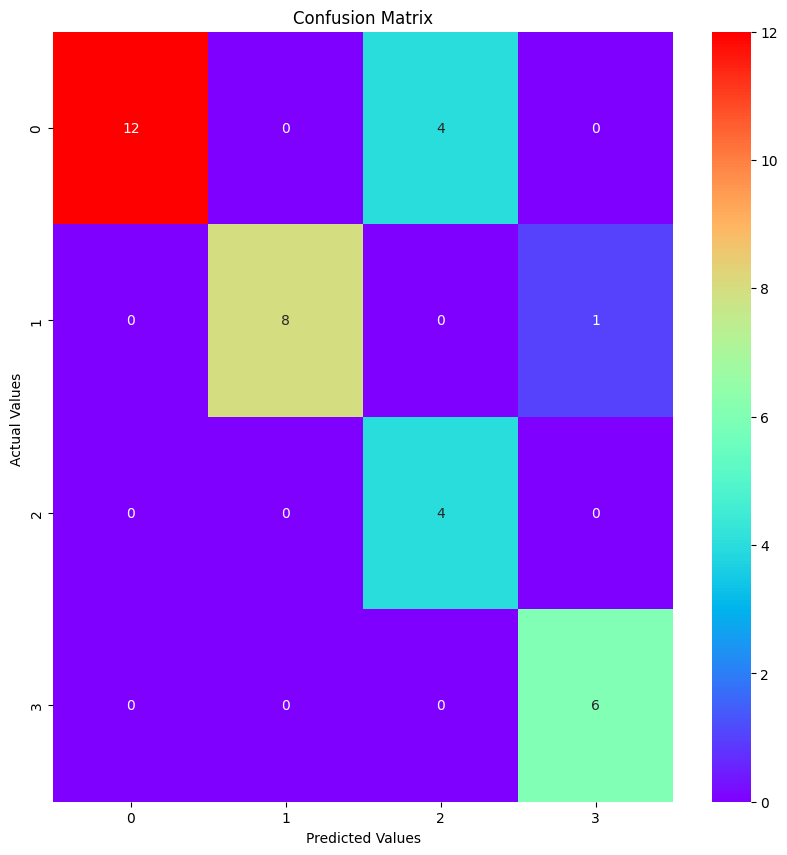

In [ ]:
conf_mx = pd.DataFrame(confusion_matrix(preds, y_test))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='rainbow', ax=ax)
ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

In [ ]:
torch.save(resnet,'/content/drive/MyDrive/детекция/' +'resnet18_finals.pth')

**Вывод**
Таким образом, лучшей моделью стала ResNet18, которая на тестовых данных показала результат от 84% до 92%. Такие колебания связаны с тем, что при аугментации я случайным образом поворачивал каждое изображение, увеличивал масштаб и применял различные фильтры. В итоге была сохранена модель с наилучшими показателями, которая достигла 92% точности на тестовой выборке.